In [2]:
import numpy as np
from scipy.stats import linregress
import matplotlib.ticker as mtick

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex

In [2]:
# read in data containing lip syncing data
lip_syncing_data = pd.read_excel('data/regular_season_lip_syncs.xlsx')

# repeat a similar process for the all start lipsyncing data
all_star_lip_syncing_data = pd.read_excel('data/all_star_lip_syncs.xlsx')

# combine the dataset into one
lip_syncing_data = pd.concat([lip_syncing_data, all_star_lip_syncing_data], ignore_index=True)


In [235]:
# remove the rows where there are either no winner or no loser
lip_syncing_data = lip_syncing_data.dropna(subset=['Winner', 'Loser'])
# drop rows that are just a repeat of the header
lip_syncing_data = lip_syncing_data[~lip_syncing_data.Winner.str.contains('Winner')]

# remove rows where there are multiple winners or losers, as it's a non-standard format
lip_syncing_data = lip_syncing_data[~lip_syncing_data.Winner.str.contains('&|Team|\(with')]

# strip string columns of trailing whitespaces
# convert the winner, loser, song, artist, and type columns to string
for col in ['Winner', 'Loser', 'Song', 'Artist', 'Type']:
    lip_syncing_data[col] = lip_syncing_data[col].str.strip().astype(str)


# Increase consistency in queen's names
lip_syncing_data = lip_syncing_data.replace('Vanessa Vanjie', 'Vanessa Vanjie Mateo').replace('Aja LaBeija', 'Aja').replace('Eureka!', 'Eureka').replace('Kylie Sonique Love', 'Sonique')

# reduce the number of unique values in the type column
# if LaLaPARuZa is contained in the type column, replace the entire cell with simply LaLaPaRUZa
lip_syncing_data['Type'] = lip_syncing_data['Type'].apply(lambda x: 'LaLaPaRUza' if 'LaLaPaRUza' in x else x)
# same with Finale
lip_syncing_data['Type'] = lip_syncing_data['Type'].apply(lambda x: 'Finale' if (('Finale' in x) or ('Top' in x)) else x)

# drop the index column and save to a new csv
lip_syncing_data = lip_syncing_data.drop(columns='Index')

# output the cleaned data to a new csv
lip_syncing_data.to_csv('data/combined_lip_syncing_data.csv', index=False)

In [200]:
# cleaning the songs db
songs_db = pd.read_excel('data/songs_db.xlsx')

# enforce string type in the Race column
songs_db['Race'] = songs_db['Race'].astype(str)

# for the race column, remove everything inside a parenthesis
# make sure that parenthesis only forms pairs with the closest parenthesis
songs_db['Race'] = songs_db['Race'].apply(lambda x: regex.sub(r'\(.*?\)', '', x))

# remove white spaces in the race column
songs_db['Race'] = songs_db['Race'].str.replace(' ', '')

replace_dict = {
    "Latina": "Hispanic",
    "White,Black":"Mixed",
    "Black,White":"Mixed", 
    "White,White":"White",
    "Latina,Latino":"Hispanic",
    "Latina,White":"Mixed",
    "Latina,Latina":"Hispanic"}

# do replacement on the race columns
songs_db['Race'] = songs_db["Race"].replace(replace_dict)

# clean up trailing whitespaces in the song and singer columns
songs_db['Song'] = songs_db['Song'].str.strip()
songs_db['Singer'] = songs_db['Singer'].str.strip()

songs_db.to_csv('data/cleaned_songs_db.csv', index=False)

In [261]:
# read in the drag queen data
queens_data = pd.read_excel('data/drag_queens_db.xlsx')

# replace middle eastern with white
# replace pacific islander and hawaiian with asian
queens_data = queens_data.replace('Middle Eastern', 'White').replace('Pacific Islander', 'Asian').replace('Hawaiian', 'Asian').replace("South Asian", "Asian")

# convert the height column to float by converting the inches to feet
queens_data['Height'] = queens_data['Height'].apply(lambda x: float(x.split('\'')[0]) + float(x.split('\'')[1].replace('"', ''))/12)

# save the cleaned data to a new csv
queens_data.to_csv('data/cleaned_queens_data.csv', index=False)

In [3]:
# read in the combined lip syncing data
lip_syncing_data = pd.read_csv('data/combined_lip_syncing_data.csv')

# read in the cleaned songs db
songs_db = pd.read_csv('data/cleaned_songs_db.csv')

# read in the cleaned queens data
queens_db = pd.read_csv('data/cleaned_queens_data.csv')
# attach information about the queens to the lip syncing data, drop the drag queen column
lip_syncing_data = lip_syncing_data.merge(queens_db, left_on='Winner', right_on='Drag Queen', how='left').drop(columns='Drag Queen')
lip_syncing_data = lip_syncing_data.merge(queens_db, left_on='Loser', right_on='Drag Queen', how='left', suffixes=('_winner', '_loser')).drop(columns='Drag Queen')
# attach information about the songs to the lip syncing data
lip_syncing_data = lip_syncing_data.merge(songs_db, left_on=['Song','Artist'],right_on=["Song","Singer"], how='left').drop(columns='Singer')

# rename the "race" column as "singer race"
lip_syncing_data = lip_syncing_data.rename(columns = {"Race":"singer race"})


In [4]:
features= lip_syncing_data.drop(columns=['Winner', 'Loser', 'Song', 'Artist','Episode'])

# create two copy of the data from winner and loser's perspective respectively
features_winner = features.copy()
# rename the columns to reflect that it's from the winner's perspective
features_winner.columns = [col.replace('winner','queen1') for col in features_winner.columns]
features_winner.columns = [col.replace('loser','queen2') for col in features_winner.columns]
# add results
features_winner['result'] = True

features_loser = features.copy()
# rename the columns to reflect that it's from the loser's perspective  
features_loser.columns = [col.replace('loser','queen1') for col in features_loser.columns]
features_loser.columns = [col.replace('winner','queen2') for col in features_loser.columns]
# add results
features_loser['result'] = False

# combine the two dataframes
features_ext = pd.concat([features_winner, features_loser], ignore_index=True)
features_ext = features_ext.dropna(how = 'any')    

In [5]:
# feature construction
# race_adv is defined as when queen1's race equals to the singers, and queen2 does not
features_ext["race_adv"] = (features_ext["Race_queen1"] == features_ext["singer race"]) & (features_ext["Race_queen2"] != features_ext["singer race"])

# create a new feature that is the difference in height between the two queens
features_ext['height_diff'] = features_ext['Height_queen1'] - features_ext['Height_queen2']

# create a new feature that calculates which queen's 25-year-old period is closer to the publication year of the song
queen1_era_shift = abs(features_ext['Birth Year_queen1'] + 25 - features_ext['Year of Publication'])
queen2_era_shift = abs(features_ext['Birth Year_queen2'] + 25 - features_ext['Year of Publication'])
features_ext['era_adv'] = queen2_era_shift -queen1_era_shift

# construct a new parameter to represent the age gap between queens
features_ext['age_gap'] = features_ext['Birth Year_queen1'] - features_ext['Birth Year_queen2']

Text(0, 0.5, 'Win ratio')

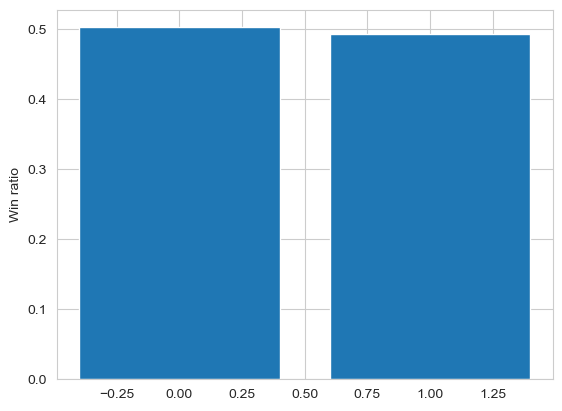

In [6]:
# plot the win ratio as a function of whether there is race advantage
win_rate = features_ext.groupby('race_adv')['result'].mean()
plt.bar(win_rate.index, win_rate.values)
# add yaxis label
plt.ylabel('Win ratio')


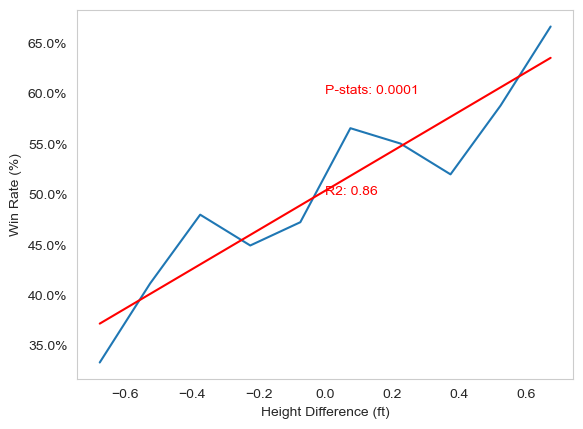

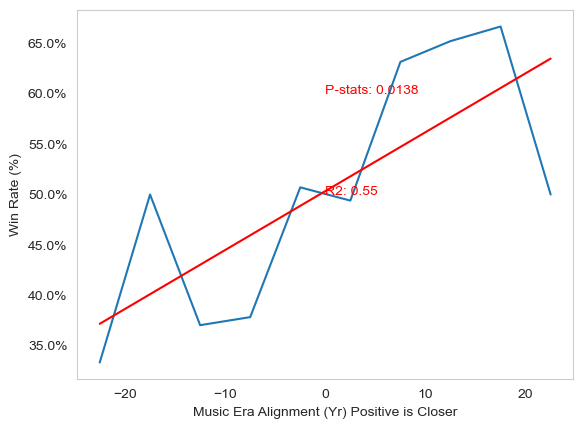

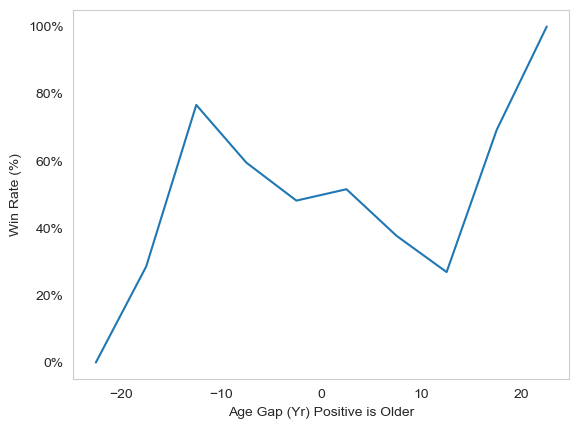

In [10]:
x_labels = {"height_diff": "Height Difference (ft)",
            "era_adv": "Music Era Alignment (Yr) Positive is Closer",
            "age_gap": "Age Gap (Yr) Positive is Older"}
            
for feat in ["height_diff","era_adv","age_gap"]:
    # explore the relationship between indicators and the result of the lip sync
    fig, ax = plt.subplots()
    # plot the win ratio as a function of the height difference
    win_rate = features_ext.groupby(pd.cut(features_ext[feat], 10), observed = False)['result'].mean()
    # convert the index to the midpoint of the bin
    win_rate.index = win_rate.index.map(lambda x: x.mid)
    ax.plot(win_rate.index, win_rate.values)
    
    # remove grid but keep border box
    ax.grid(False)

    # put y-axis into percentile scale
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
    # don't fit age_gap to a linear model
    if feat != "age_gap":
    
        # add a fitted linear regression line and print out R2 and P-value
        slope, intercept, r_value, p_value, std_err = linregress(win_rate.index, win_rate.values)
        ax.plot(win_rate.index, slope * win_rate.index.astype(float) + intercept, color='red')
    
        ax.text(0, 0.5, f'R2: {r_value**2:.2f}', color='red')
        ax.text(0, 0.6, f'P-stats: {p_value:.4f}', color='red')
    
    plt.xlabel(x_labels[feat])
    plt.ylabel('Win Rate (%)')
    
    # save the figure
    fig.savefig(f'figures/{feat}_win_rate.png', dpi = 300)
    


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# build a new model based on the new features
X = features_ext[['height_diff', 'era_adv', 'age_gap']]
y = features_ext['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('height_diff', StandardScaler(), ['height_diff']),
        ('age_related', StandardScaler(), ['era_adv','age_gap']),
        # ('height', StandardScaler(), ['Height_queen1', 'Height_queen2']),
        # ('race', OneHotEncoder(),['Race_queen1', 'Race_queen2', 'singer race']),
        # ('type', OneHotEncoder(), ['Type']),
        # ('year',StandardScaler(),['Birth Year_queen1','Birth Year_queen2','Year of Publication']),
        # ('season', StandardScaler(), ['Season'])
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=5, random_state=42))
])

pipe.fit(X_train, y_train)

print(f'Training accuracy: {pipe.score(X_train, y_train)}')

y_pred = pipe.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion matrix: {confusion}')

Training accuracy: 0.7075268817204301
Accuracy: 0.6153846153846154
Confusion matrix: [[36 19]
 [26 36]]
